In [44]:
import jax
import jax.numpy as jnp
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="whitegrid")

In [71]:
@jax.jit
def beale(theta: jnp.DeviceArray) -> jnp.DeviceArray:
    x = jnp.dot(theta, jnp.array([1., 0.]))
    y = jnp.dot(theta, jnp.array([0., 1.]))
    xy = jnp.dot(x, y)
    xyy = jnp.dot(xy, y)
    xyyy = jnp.dot(xyy, y)
    return jnp.power(1.5 - x + xy, 2) + jnp.power(2.25 - x + xyy, 2) + jnp.power(2.625 - x + xyyy, 2)


@jax.jit
def rosenbrock(theta: jnp.DeviceArray) -> jnp.DeviceArray:
    x = jnp.dot(theta, jnp.array([1., 0.]))
    y = jnp.dot(theta, jnp.array([0., 1.]))
    return jnp.power(1 - x, 2) + 100 * jnp.power(y - x * x, 2)


class SGD(object):

    def __init__(self, params, momentum=0, dampening=0, eta=1e-3, nestereov=False):
        self.shape = params.shape
        self.momentum = momentum
        self.dampening = dampening
        self.eta = eta
        self.nesterov = nestereov
        self.prev_grad = None
        self.t = 0

    def __update(self, params: jnp.DeviceArray, grad: jnp.DeviceArray) -> jnp.DeviceArray:

        if self.momentum != 0:
            if self.t == 0:
                self.b = grad
            else:
                self.b = self.momentum * self.b + (1 - self.dampening) * grad

            if self.nesterov and self.t > 0:
                grad = self.prev_grad + self.momentum * self.b
            else:
                grad = self.b

        self.prev_grad = grad
        self.t += 1
        return params - self.eta * grad

    def forward_update(self, params, key, loss):
        v = jax.random.normal(key, shape=self.shape)
        _, dd = jax.jvp(loss, (params,), (v,))
        return self.__update(params, dd * v)

    def backward_update(self, params, loss):
        grad = jax.grad(loss)(params)
        return self.__update(params, grad)


In [73]:
theta = jnp.array([0., 0.5])
xs = []
ys = []
f_val = []

optim = SGD(theta, eta=0.01)

for i in tqdm(range(1000)):
    theta = optim.forward_update(theta, jax.random.PRNGKey(i), beale)
    xs.append(float(theta[0]))
    ys.append(float(theta[1]))
    f_val.append(float(beale(theta)))

100%|██████████| 1000/1000 [00:03<00:00, 271.26it/s]


In [66]:
theta = jnp.array([0., 0.5])
xs_1 = []
ys_1 = []
f_val_1 = []

optim = SGD(theta, eta=0.01)

for i in tqdm(range(1000)):
    theta = optim.backward_update(theta, beale)
    xs_1.append(float(theta[0]))
    ys_1.append(float(theta[1]))
    f_val_1.append(float(beale(theta)))

100%|██████████| 1000/1000 [00:04<00:00, 244.50it/s]


Text(0.5, 1.0, 'Params')

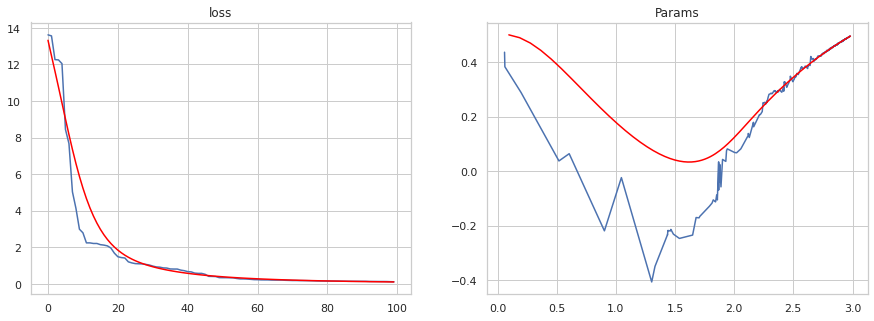

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x=[i for i in range(100)], y=f_val[:100], ax=ax[0])
sns.lineplot(x=[i for i in range(100)], y=f_val_1[:100], ax=ax[0], color='red')
# add title : loss
ax[0].set_title('loss')
sns.lineplot(x=xs, y=ys, ax=ax[1])
sns.lineplot(x=xs_1, y=ys_1, ax=ax[1], color='red')
ax[1].set_title('Params')